In [1]:
import pandas as pd
import numpy as np
import keras 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import LSTM, BatchNormalization,concatenate,Flatten,Embedding,Dense,Dropout,Reshape
from keras import Model,Input
from keras.preprocessing.text import one_hot
from sklearn.model_selection import train_test_split
from keras.regularizers import l2
from time import time
from tensorflow.python.keras.callbacks import TensorBoard

Using TensorFlow backend.


In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

## Google Colab Stuff

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link = 'https://drive.google.com/open?id=10nvn3wpB-lwwj7dT5BhAgFjwZXw5pS5D'

In [6]:
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

10nvn3wpB-lwwj7dT5BhAgFjwZXw5pS5D


In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('preprocessed_complete.csv')  
df= pd.read_csv('preprocessed_complete.csv')

## Preprocessing

In [8]:
df.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,essay,price,quantity,std_price,nrm_price,presence_of_the_numerical_digits
0,0,p253737,c90749f5d961ff158d4b4d1e7dc665fc,mrs,in,2016-12-05 13:43:57,grades_prek_2,literacy_language,esl_literacy,Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,My students are English learners that are work...,154.6,23,-0.390533,0.015397,0
1,1,p258326,897464ce9ddc600bced1151f324dd63a,mr,fl,2016-10-25 09:22:10,grades_6_8,history_civics_health_sports,civics_government_teamsports,Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,Our students arrive to our school eager to lea...,299.0,1,0.002396,0.029839,0


In [9]:
df.drop(['Unnamed: 0'],axis = 1,inplace = True)
df.head(2)

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,essay,price,quantity,std_price,nrm_price,presence_of_the_numerical_digits
0,p253737,c90749f5d961ff158d4b4d1e7dc665fc,mrs,in,2016-12-05 13:43:57,grades_prek_2,literacy_language,esl_literacy,Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,My students are English learners that are work...,154.6,23,-0.390533,0.015397,0
1,p258326,897464ce9ddc600bced1151f324dd63a,mr,fl,2016-10-25 09:22:10,grades_6_8,history_civics_health_sports,civics_government_teamsports,Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,Our students arrive to our school eager to lea...,299.0,1,0.002396,0.029839,0


In [0]:
y=df['project_is_approved']

In [0]:
df['total_text']=df['project_title']+' '+df['essay']+' '+df['project_resource_summary']

In [0]:
df=df[['total_text','school_state','project_grade_category','project_subject_categories','project_subject_subcategories','teacher_prefix','teacher_number_of_previously_posted_projects','presence_of_the_numerical_digits','price','quantity']]

In [13]:
df.head(2)

,total_text,school_state,project_grade_category,project_subject_categories,project_subject_subcategories,teacher_prefix,teacher_number_of_previously_posted_projects,presence_of_the_numerical_digits,price,quantity
0,Educational Support for English Learners at Ho...,in,grades_prek_2,literacy_language,esl_literacy,mrs,0,0,154.6,23
1,Wanted: Projector for Hungry Learners Our stud...,fl,grades_6_8,history_civics_health_sports,civics_government_teamsports,mr,7,0,299.0,1


In [0]:
X_train,X_test,y_train,y_test=train_test_split(df,y,stratify = y, test_size = 0.3)
X_train,X_cv,y_train,y_cv=train_test_split(X_train,y_train,stratify = y_train, test_size = 0.2)

In [ ]:
from keras.utils import to_categorical
y_train=to_categorical(y_train)
y_test=to_categorical(y_test)
y_cv=to_categorical(y_cv)

## Total_text_feature

In [0]:
total_text=X_train.total_text.values

In [0]:
#https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17
t = Tokenizer()
t.fit_on_texts(total_text)

In [0]:
len_input1 = len(t.word_index) + 1

In [18]:
len_input1


57485

In [0]:
# Converting Textual Data to Numerical form so we can use this in Embedding Layer
encoded_docs_train = t.texts_to_sequences(total_text)
encoded_docs_train=np.array(encoded_docs_train)
encoded_docs_train=pad_sequences(encoded_docs_train, maxlen=300, padding='post')

In [0]:
encoded_docs_cv = t.texts_to_sequences(X_cv.total_text)
encoded_docs_cv=np.array(encoded_docs_cv)
encoded_docs_cv=pad_sequences(encoded_docs_cv, maxlen=300, padding='post')

In [0]:
encoded_docs_test = t.texts_to_sequences(X_test.total_text)
encoded_docs_test=np.array(encoded_docs_test)
encoded_docs_test=pad_sequences(encoded_docs_test, maxlen=300, padding='post')

In [0]:
link = 'https://drive.google.com/open?id=1jyOxxCTqzM-eKXUc8qxGTZPgqkd-zUKC'
fluff, id = link.split('=')

In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('glove_vectors')  

In [0]:
# Using Pretrained Glove Embedding Model
import pickle
glove = open('glove_vectors', 'rb')      
glove = pickle.load(glove)

In [0]:
embedding_matrix = np.zeros((len_input1, 300))
for word, i in t.word_index.items():
    embedding_vector = glove.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [26]:
embedding_matrix.shape

(57485, 300)

# Combining All other features 

## School State Feature

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

In [0]:
cv=CountVectorizer()
ss_train=cv.fit_transform(X_train.school_state.values)
ss_cv=cv.transform(X_cv.school_state)
ss_test=cv.transform(X_test.school_state)

In [30]:
ss_train.shape

(61178, 51)

## Project Grade Category Feature

In [0]:
cv=CountVectorizer()
pgc_train=cv.fit_transform(X_train.project_grade_category.values)
pgc_cv=cv.transform(X_cv.project_grade_category)
pgc_test=cv.transform(X_test.project_grade_category)

In [32]:
pgc_train.shape

(61178, 4)

## Project Subject Category Feature

In [0]:
cv=CountVectorizer()
psc_train=cv.fit_transform(X_train.project_subject_categories.values)
psc_cv=cv.transform(X_cv.project_subject_categories)
psc_test=cv.transform(X_test.project_subject_categories)

In [34]:
psc_train.shape

(61178, 51)

## Project Subject SubCategory Feature

In [0]:
cv=CountVectorizer()
pssc_train=cv.fit_transform(X_train.project_subject_subcategories.values)
pssc_cv=cv.transform(X_cv.project_subject_subcategories)
pssc_test=cv.transform(X_test.project_subject_subcategories)

In [36]:
pssc_train.shape

(61178, 387)

## Teacher_prefix Feature

In [0]:
cv=CountVectorizer()
tp_train=cv.fit_transform(X_train.teacher_prefix.values)
tp_cv=cv.transform(X_cv.teacher_prefix)
tp_test=cv.transform(X_test.teacher_prefix)

In [38]:
tp_train.shape

(61178, 5)

In [39]:
df.head(2)

,total_text,school_state,project_grade_category,project_subject_categories,project_subject_subcategories,teacher_prefix,teacher_number_of_previously_posted_projects,presence_of_the_numerical_digits,price,quantity
0,Educational Support for English Learners at Ho...,in,grades_prek_2,literacy_language,esl_literacy,mrs,0,0,154.6,23
1,Wanted: Projector for Hungry Learners Our stud...,fl,grades_6_8,history_civics_health_sports,civics_government_teamsports,mr,7,0,299.0,1


## Numerical Features

In [0]:
X_train_numeric=[]
for i in range(X_train.shape[0]):
    vec=[]
    vec.append(X_train.iloc[i,6])
    vec.append(X_train.iloc[i,7])
    vec.append(X_train.iloc[i,8])
    vec.append(X_train.iloc[i,9])
    X_train_numeric.append(vec)
X_train_numeric=np.array(X_train_numeric)    

In [41]:
X_train_numeric.shape

(61178, 4)

In [0]:
X_cv_numeric=[]
for i in range(X_cv.shape[0]):
    vec=[]
    vec.append(X_cv.iloc[i,6])
    vec.append(X_cv.iloc[i,7])
    vec.append(X_cv.iloc[i,8])
    vec.append(X_cv.iloc[i,9])
    X_cv_numeric.append(vec)
    
X_cv_numeric=np.array(X_cv_numeric)

In [0]:
X_test_numeric=[]
for i in range(X_test.shape[0]):
    vec=[]
    vec.append(X_test.iloc[i,6])
    vec.append(X_test.iloc[i,7])
    vec.append(X_test.iloc[i,8])
    vec.append(X_test.iloc[i,9])
    X_test_numeric.append(vec)
X_test_numeric=np.array(X_test_numeric)

In [0]:
from scipy.sparse import hstack

In [0]:
cnn_train=hstack((ss_train,pgc_train,psc_train,pssc_train,tp_train,X_train_numeric))

In [46]:
cnn_train.shape

(61178, 502)

In [47]:
cnn_cv=hstack((ss_cv,pgc_cv,psc_cv,pssc_cv,tp_cv,X_cv_numeric))
cnn_cv.shape

(15295, 502)

In [48]:
cnn_test=hstack((ss_test,pgc_test,psc_test,pssc_test,tp_test,X_test_numeric))
cnn_test.shape

(32775, 502)

In [49]:
len_input2=cnn_train.shape[1]
print(len_input2)

502


In [0]:
cnn_train=cnn_train.todense()
cnn_cv=cnn_cv.todense()
cnn_test=cnn_test.todense()


In [0]:
# As we are using Conv1D so resizing the data
cnn_train=np.resize(cnn_train,new_shape=(61178,len_input2,1))
cnn_cv=np.resize(cnn_cv,new_shape=(15295,len_input2,1))
cnn_test=np.resize(cnn_test,new_shape=(32775,len_input2,1))

In [52]:
cnn_train.shape

(61178, 502, 1)

##  Model

In [0]:
import tensorflow as tf
from sklearn.metrics import roc_auc_score

def auroc(y_true,y_pred):
    return tf.py_func(roc_auc_score,(y_true,y_pred),tf.double)

In [59]:
!pip install tensorboardcolab
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback

tbc=TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
https://7c1bd53c.ngrok.io


In [60]:
from keras.layers import Conv1D,SpatialDropout1D
from keras.callbacks import TensorBoard


input1=Input(shape=(300,))
x1=Embedding(len_input1, 300, weights=[embedding_matrix], trainable=False)(input1)
x1=SpatialDropout1D(0.3)(x1) 
x1=LSTM(256,return_sequences=True)(x1)
x1=Flatten()(x1)

input2=Input(shape=(len_input2,1))
x2=Conv1D(filters=64,kernel_size=3,strides=1)(input2)
x2=Conv1D(filters=64,kernel_size=3,strides=1)(x2)
x2=Flatten()(x2)

concat=concatenate([x1,x2])
x=Dense(300,activation='relu',kernel_initializer='he_normal',kernel_regularizer=l2(0.0001))(concat)
x=Dropout(0.35)(x)
x=Dense(250,activation='relu',kernel_initializer='he_normal',kernel_regularizer=l2(0.0001))(x)
x=Dropout(0.45)(x)
x=BatchNormalization()(x)
x=Dense(100,activation='relu',kernel_initializer='he_normal',kernel_regularizer=l2(0.0001))(x)
x=Dropout(0.5)(x)
output = Dense(2, activation = 'softmax')(x)
 
model=Model([input1,input2], output)

tensorboard=TensorBoard(log_dir="logs")

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[auroc])

print(model.summary())




Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 300, 300)     17245500    input_5[0][0]                    
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 502, 1)       0                                            
__________________________________________________________________________________________________
spatial_dropout1d_3 (SpatialDro (None, 300, 300)     0           embedding_3[0][0]                
____________________________________________________________________________________________

In [61]:
#keras.backend.get_session().run(tf.global_variables_initializer())
model.fit([encoded_docs_train,cnn_train], y_train, epochs=30,verbose=1,batch_size=256,class_weight='balanced',
          validation_data=([encoded_docs_cv,cnn_cv]  , y_cv),callbacks=[TensorBoardColabCallback(tbc)] )

Train on 61178 samples, validate on 15295 samples
Epoch 1/30
61178/61178 [==============================] - 192s 3ms/step - loss: 0.7093 - auroc: 0.5304 - val_loss: 0.5693 - val_auroc: 0.5926
Epoch 2/30
61178/61178 [==============================] - 191s 3ms/step - loss: 0.5412 - auroc: 0.5556 - val_loss: 0.5137 - val_auroc: 0.6023
Epoch 3/30
61178/61178 [==============================] - 194s 3ms/step - loss: 0.5012 - auroc: 0.5760 - val_loss: 0.4976 - val_auroc: 0.5962
Epoch 4/30
61178/61178 [==============================] - 190s 3ms/step - loss: 0.4868 - auroc: 0.5731 - val_loss: 0.4888 - val_auroc: 0.6045
Epoch 5/30
61178/61178 [==============================] - 193s 3ms/step - loss: 0.4779 - auroc: 0.5808 - val_loss: 0.4917 - val_auroc: 0.5973
Epoch 6/30
61178/61178 [==============================] - 191s 3ms/step - loss: 0.4780 - auroc: 0.5768 - val_loss: 0.4697 - val_auroc: 0.5963
Epoch 7/30
61178/61178 [==============================] - 191s 3ms/step - loss: 0.4665 - auroc: 0.

In [0]:
pred=model.predict([encoded_docs_test,cnn_test])

In [63]:
roc_auc_score(y_test,pred)

0.7711299992734963

### Loss with Epochs[Training:Orange, Validation:Blue]

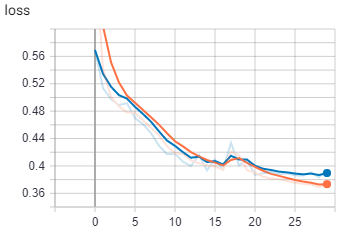

In [4]:
from IPython.display import Image
Image(filename='model3_loss.png')

#### As we can see training and validation loss are very close so there is no overfitting and our model is fine

### AUC with Epochs[Training:Orange, Validation:Blue]

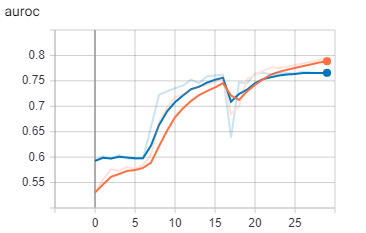

In [5]:
from IPython.display import Image
Image(filename='model3_auc.png')

# Conclusion

* In this model we created two inputs, First Input will take the total Textual features like project title, Essay, Project Resource Summary and the second input will take the all other remaining features
* First Input will be passed to a LSTM Layer 
* Second Input will be passed to an Conv1d Layer
* We have used L2 regularizer to prevent our model from overfitting 
* we have used adam optimizer
* After 25 Epochs:
    Training Loss-0.3739
    Validation Loss-0.3940
    Training AUC-0.7928
    Validation AUC-0.7661
* Testing AUC of this Model is 0.7711299992734963